In [ ]:
!pip install hypnettorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.9/456.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = '.'

Reading CIFAR-10 dataset ...
Elapsed time to read dataset: 14.657604 sec


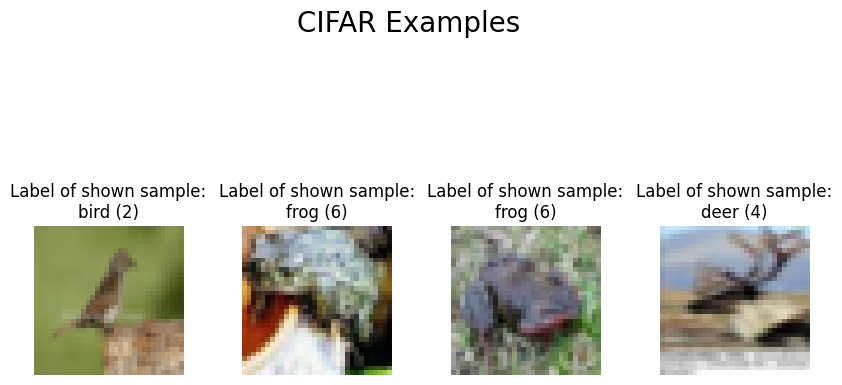

In [ ]:
from hypnettorch.data import CIFAR10Data

#Import CIFAR Dataset
cifar = CIFAR10Data(data_dir, use_one_hot=True, validation_size=0)

# Get a batch of training samples from each data handler.
cifar_inps, cifar_trgts = cifar.next_train_batch(4)

# Plot sample MNIST data
cifar.plot_samples('CIFAR Examples', cifar_inps, outputs=cifar_trgts)

In [ ]:
print(cifar.in_shape)
print(cifar.num_classes)

[32, 32, 3]
10


In [ ]:
from hypnettorch.mnets import ResNet

# Instantiate Target ResNet
mnet = ResNet(in_shape=[32, 32, 3], num_classes=cifar.num_classes).to(device)

A ResNet with 32 layers and 465290 weights is created. The network uses batchnorm.


In [ ]:
from hypnettorch.hnets import HMLP

# Instantiate Hypernetwork HMLP
hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8, layers=[100, 100], num_cond_embs=2).to(device)

print('The randomly initialized input embeddings are:\n', hnet.conditional_params)

Created MLP Hypernet.
Hypernetwork with 47005306 weights and 465290 outputs (compression ratio: 101.02).
The network consists of 47005290 unconditional weights (47005290 internally maintained) and 16 conditional weights (16 internally maintained).
The randomly initialized input embeddings are:
 [Parameter containing:
tensor([-0.5264, -1.7299,  0.7204,  0.4023, -0.4903,  0.1417,  1.2846,  0.3790],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.1581, -0.6890,  0.8845,  0.1472, -0.2655, -1.4336, -0.3083, -0.2555],
       device='cuda:0', requires_grad=True)]


In [ ]:
# Initialize network
hnet.apply_hyperfan_init(mnet=mnet)

In [ ]:
# Accuracy 

def calc_accuracy(data, mnet, mnet_weights):
    """Compute the test accuracy for a given dataset"""
    with torch.no_grad():
        # Process complete test set as one batch.
        test_in = data.input_to_torch_tensor( \
            data.get_test_inputs(), device, mode='inference')
        test_out = data.input_to_torch_tensor( \
            data.get_test_outputs(), device, mode='inference')
        test_lbls = test_out.max(dim=1)[1]

        logits = mnet(test_in, weights=mnet_weights)
        pred_lbls = logits.max(dim=1)[1]

        acc = torch.sum(test_lbls == pred_lbls) / test_lbls.numel() * 100.

    return acc

In [ ]:
# Configure training

lr=1e-4
batchsize=32
nepochs=10
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(nepochs): # For each epoch.

    # Iterate over the whole CIFAR training set.
    i = 0
    for curr_batchsize, mx, my in cifar.train_iterator(batchsize):
        i += 1

        # Current mini-batch of CIFAR samples.
        cifar_X = cifar.input_to_torch_tensor(mx, device, mode='train')
        cifar_Y = cifar.output_to_torch_tensor(my, device, mode='train')

        optimizer.zero_grad()

        # Compute CIFAR loss.
        W_cifar = hnet(cond_id=0)
        cifar_P = mnet.forward(cifar_X, weights=W_cifar)
        loss_cifar = criterion(cifar_P, cifar_Y.max(dim=1)[1])
        
        # The total loss (add regularizers here)
        loss = loss_cifar
        loss.backward()
        optimizer.step()

        if i % 500 == 0:            
            print('[%d, %5d] loss: %.3f, CIFAR-10 acc: %.2f%%' % (epoch + 1, i + 1, loss.item(), calc_accuracy(cifar, mnet, W_cifar)))


print('Training finished with test-accs: CIFAR-10 acc: %.2f%%' % (calc_accuracy(cifar, mnet, W_cifar)))

[1,   501] loss: 1.668, CIFAR-10 acc: 43.41%
[1,  1001] loss: 1.380, CIFAR-10 acc: 56.41%
[1,  1501] loss: 1.166, CIFAR-10 acc: 62.29%
[2,   501] loss: 1.006, CIFAR-10 acc: 66.47%
[2,  1001] loss: 0.860, CIFAR-10 acc: 68.55%
[2,  1501] loss: 0.910, CIFAR-10 acc: 72.43%
[3,   501] loss: 0.777, CIFAR-10 acc: 73.60%
[3,  1001] loss: 0.721, CIFAR-10 acc: 76.52%
[3,  1501] loss: 0.644, CIFAR-10 acc: 74.56%
[4,   501] loss: 0.490, CIFAR-10 acc: 78.14%
[4,  1001] loss: 0.661, CIFAR-10 acc: 77.15%
[4,  1501] loss: 0.323, CIFAR-10 acc: 78.98%
[5,   501] loss: 0.597, CIFAR-10 acc: 79.81%
[5,  1001] loss: 0.589, CIFAR-10 acc: 81.27%
[5,  1501] loss: 0.291, CIFAR-10 acc: 81.73%
[6,   501] loss: 0.520, CIFAR-10 acc: 81.47%
[6,  1001] loss: 0.729, CIFAR-10 acc: 80.91%
[6,  1501] loss: 0.491, CIFAR-10 acc: 82.47%
[7,   501] loss: 0.269, CIFAR-10 acc: 81.76%
[7,  1001] loss: 0.637, CIFAR-10 acc: 82.39%
[7,  1501] loss: 0.397, CIFAR-10 acc: 82.83%
[8,   501] loss: 0.319, CIFAR-10 acc: 82.37%
[8,  1001]

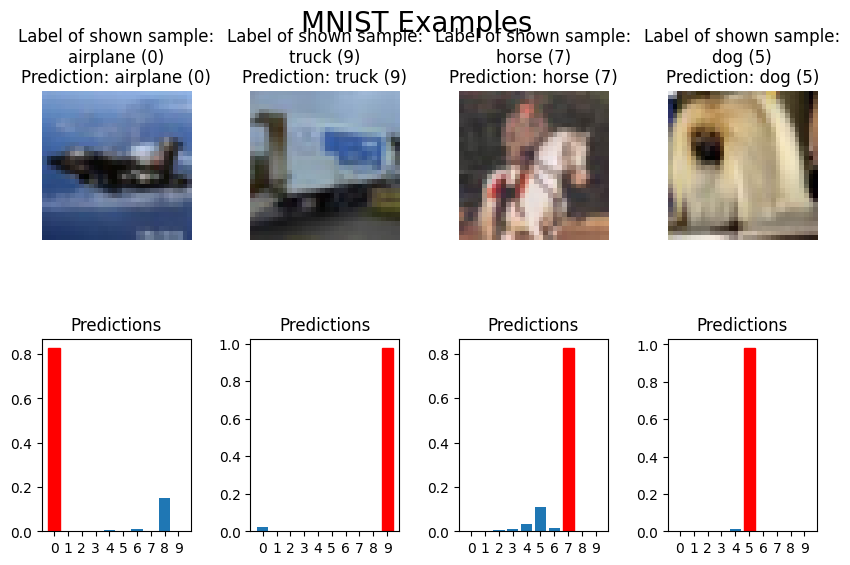

In [ ]:
# Get a batch of test samples from each data handler.
cifar_inps, cifar_trgts = cifar.next_test_batch(4)

# Compute predictions for test batches above.
with torch.no_grad():
    cifar_X = cifar.input_to_torch_tensor(cifar_inps, device, mode='inference')
    
    W_cifar = hnet(cond_id=0)
    cifar_preds = mnet.forward(cifar_X, weights=W_cifar)
    
    # Note, the network outputs are logits, and thus not normalized.
    mnist_preds = torch.softmax(cifar_preds, dim=1)
    
    mnist_preds = mnist_preds.detach().cpu().numpy()

cifar.plot_samples('MNIST Examples', cifar_inps, outputs=cifar_trgts,
                   predictions=mnist_preds)